In [1]:
import numpy as np
#import cupy as cp
import matplotlib.pyplot as plt
from scipy import stats

MHD-PIC : S. Usami et al., 2013 スタイル \
MHD・PICそれぞれでinterface分を確保することにする。\
そのうえで、interface領域を指定して両者間のやり取りを行う。

PICパート

In [2]:
def get_rho(q, x, n_x, dx, rho):
    x_index = np.floor(x[0, :] / dx).astype(np.int64)

    cx1 = (x[0, :] - x_index*dx)/dx  
    cx2 = ((x_index+1)*dx - x[0, :])/dx 
    index_one_array = x_index

    rho += np.bincount(index_one_array, 
                       weights=q * cx2,
                       minlength=n_x
                      )
    rho += np.roll(np.bincount(index_one_array, 
                               weights=q * cx1,
                               minlength=n_x
                              ), 1, axis=0)
    
    return rho


def get_current_density(c, q, v, x, n_x, dx, current):
    x_index = np.floor(x[0, :] / dx).astype(int)
    x_index_half = np.floor((x[0, :] - 1/2*dx) / dx).astype(int)
    x_index_half_minus = np.where(x_index_half == -1)
    x_index_half[x_index_half == -1] = n_x-1

    gamma = np.sqrt(1.0 + (np.linalg.norm(v, axis=0)/c)**2)

    cx1 = (x[0, :] - (x_index_half + 1/2)*dx)/dx  
    cx2 = ((x_index_half + 3/2)*dx - x[0, :])/dx 
    cx1[x_index_half_minus] = (x[0, x_index_half_minus] - (-1/2)*dx)/dx  
    cx2[x_index_half_minus] = ((1/2)*dx - x[0, x_index_half_minus])/dx 
    index_one_array = x_index_half

    current[0, :] += np.bincount(index_one_array, 
                                 weights=q * v[0, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    current[0, :] += np.roll(np.bincount(index_one_array, 
                                         weights=q * v[0, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)

    cx1 = (x[0, :] - x_index*dx)/dx  
    cx2 = ((x_index+1)*dx - x[0, :])/dx 
    index_one_array = x_index
    
    current[1, :] += np.bincount(index_one_array, 
                                    weights=q * v[1, :]/gamma * cx2, 
                                    minlength=n_x
                                    )
    current[1, :] += np.roll(np.bincount(index_one_array, 
                                            weights=q * v[1, :]/gamma * cx1, 
                                            minlength=n_x
                                            ), 1, axis=0)

    current[2, :] += np.bincount(index_one_array, 
                                 weights=q * v[2, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    current[2, :] += np.roll(np.bincount(index_one_array, 
                                         weights=q * v[2, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    
    return current


def get_zeroth_moment(x, n_x, dx, zeroth_moment):
    x_index = np.floor(x[0, :] / dx).astype(np.int64)

    cx1 = (x[0, :] - x_index*dx)/dx  
    cx2 = ((x_index+1)*dx - x[0, :])/dx 
    index_one_array = x_index

    zeroth_moment += np.bincount(index_one_array, 
                       weights=cx2,
                       minlength=n_x
                      )
    zeroth_moment += np.roll(np.bincount(index_one_array, 
                               weights=cx1,
                               minlength=n_x
                              ), 1, axis=0)
    
    return zeroth_moment


def get_first_moment(c, v, x, n_x, dx, first_moment):
    x_index = np.floor(x[0, :] / dx).astype(int)
    x_index_half = np.floor((x[0, :] - 1/2*dx) / dx).astype(int)
    x_index_half_minus = np.where(x_index_half == -1)
    x_index_half[x_index_half == -1] = n_x-1

    gamma = np.sqrt(1.0 + (np.linalg.norm(v, axis=0)/c)**2)

    cx1 = (x[0, :] - x_index*dx)/dx  
    cx2 = ((x_index+1)*dx - x[0, :])/dx 
    index_one_array = x_index

    first_moment[0, :] += np.bincount(index_one_array, 
                                 weights=v[0, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    first_moment[0, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[0, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    first_moment[1, :] += np.bincount(index_one_array, 
                                 weights=v[1, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    first_moment[1, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[1, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    first_moment[2, :] += np.bincount(index_one_array, 
                                 weights=v[2, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    first_moment[2, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[2, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)

    return first_moment


def get_second_moment(c, v, x, n_x, dx, second_moment):
    x_index = np.floor(x[0, :] / dx).astype(int)
    x_index_half = np.floor((x[0, :] - 1/2*dx) / dx).astype(int)
    x_index_half_minus = np.where(x_index_half == -1)
    x_index_half[x_index_half == -1] = n_x-1

    gamma = np.sqrt(1.0 + (np.linalg.norm(v, axis=0)/c)**2)

    cx1 = (x[0, :] - x_index*dx)/dx  
    cx2 = ((x_index+1)*dx - x[0, :])/dx 
    index_one_array = x_index

    second_moment[0, :] += np.bincount(index_one_array, 
                                 weights=v[0, :]/gamma * v[0, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    second_moment[0, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[0, :]/gamma * v[0, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    second_moment[1, :] += np.bincount(index_one_array, 
                                 weights=v[0, :]/gamma * v[1, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    second_moment[1, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[0, :]/gamma * v[1, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    second_moment[2, :] += np.bincount(index_one_array, 
                                 weights=v[0, :]/gamma * v[2, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    second_moment[2, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[0, :]/gamma * v[2, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    second_moment[3, :] = second_moment[1, :]
    second_moment[4, :] += np.bincount(index_one_array, 
                                 weights=v[1, :]/gamma * v[1, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    second_moment[4, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[1, :]/gamma * v[1, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    second_moment[5, :] += np.bincount(index_one_array, 
                                 weights=v[1, :]/gamma * v[2, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    second_moment[5, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[1, :]/gamma * v[2, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    second_moment[6, :] = second_moment[2, :]
    second_moment[7, :] = second_moment[5, :]
    second_moment[8, :] += np.bincount(index_one_array, 
                                 weights=v[2, :]/gamma * v[2, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    second_moment[8, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[2, :]/gamma * v[2, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)

    return second_moment


def buneman_boris_v(c, dt, q, m, E, B, v):

    gamma = np.sqrt(1.0 + (np.linalg.norm(v, axis=0)/c)**2)

    #TとSの設定
    T = (q/m) * dt * B / 2.0 / gamma
    S = 2.0 * T / (1.0 + np.linalg.norm(T, axis=0)**2)

    #時間発展
    v_minus = v + (q/m) * E * (dt/2)
    v_0 = v_minus + np.cross(v_minus, T, axis=0)
    v_plus = v_minus + np.cross(v_0, S, axis=0)
    v = v_plus + (q/m) * E * (dt/2.0)

    return v 


def buneman_boris_x(c, dt, v, x):

    gamma = np.sqrt(1.0 + (np.linalg.norm(v, axis=0)/c)**2)

    x = x + v * dt / gamma

    return x


def time_evolution_v(c, E, B, x, q, m, n_x, dx, dt, v):
    E_tmp = E.copy()
    B_tmp = B.copy()
    E_tmp[0, :] = (E[0, :] + np.roll(E[0, :], 1, axis=0)) / 2.0
    B_tmp[0, :] = (B[0, :] + np.roll(B[0, :], -1, axis=0)) / 2.0
    x_index = np.floor(x[0, :] / dx).astype(int)
    x_index_half = np.floor((x[0, :] - 1/2*dx) / dx).astype(int)
    x_index_half_minus = np.where(x_index_half == -1)
    x_index_half[x_index_half == -1] = n_x-1
    E_particle = np.zeros(x.shape)
    B_particle = np.zeros(x.shape)

    #電場
    cx1 = (x[0, :] - x_index*dx)/dx  
    cx2 = ((x_index+1)*dx - x[0, :])/dx 
    cx1 = cx1.reshape(-1, 1)
    cx2 = cx2.reshape(-1, 1)
    E_particle[:, :] = (E_tmp[:, x_index].T * cx2 \
                     + E_tmp[:, (x_index+1)%n_x].T * cx1 \
                    ).T
    
    #磁場
    cx1 = (x[0, :] - (x_index_half + 1/2)*dx)/dx  
    cx2 = ((x_index_half + 3/2)*dx - x[0, :])/dx 
    cx1[x_index_half_minus] = (x[0, x_index_half_minus] - (-1/2)*dx)/dx  
    cx2[x_index_half_minus] = ((1/2)*dx - x[0, x_index_half_minus])/dx 
    cx1 = cx1.reshape(-1, 1)
    cx2 = cx2.reshape(-1, 1)
    B_particle[:, :] = (B_tmp[:, x_index_half].T * cx2 \
                     + B_tmp[:, (x_index_half+1)%n_x].T * cx1 \
                    ).T
  
    v = buneman_boris_v(c, dt, q, m, E_particle, B_particle, v)

    return v


def time_evolution_x(c, dt, v, x):
    
    x = buneman_boris_x(c, dt, v, x)

    return x 


def time_evolution_E(B, current, c, epsilon0, dx, dt, E):
    E[0, :] = -current[0, :]/epsilon0 * dt + E[0, :]
    E[1, :] = (-current[1, :]/epsilon0 \
            - c**2 * (B[2, :] - np.roll(B[2, :], 1))/dx) * dt \
            + E[1, :]
    E[2, :] = (-current[2, :]/epsilon0 \
            + c**2 * (B[1, :] - np.roll(B[1, :], 1)) / dx) * dt \
            + E[2, :]
    return E


def time_evolution_B(E, dx, dt, B):
    B[0, :] = B[0, :]
    B[1, :] = -(-(np.roll(E[2, :], -1) - E[2, :]) / dx) * dt \
            + B[1, :]
    B[2, :] = -((np.roll(E[1, :], -1) - E[1, :]) / dx) * dt \
            + B[2, :]
    return B


def periodic_condition_x(x, x_max):

    over_xmax_index = np.where(x[0, :] >= x_max)[0]
    x[0, over_xmax_index] = 1e-10

    under_x0_index = np.where(x[0, :] <= 0.0)[0]
    x[0, under_x0_index] = x_max - 1e-10

    return x 


def refrective_condition_x(v, x, x_max):

    over_xmax_index = np.where(x[0, :] >= x_max)[0]
    x[0, over_xmax_index] = x_max - 1e-10
    v[0, over_xmax_index] = -v[0, over_xmax_index]

    under_x0_index = np.where(x[0, :] <= 0.0)[0]
    x[0, under_x0_index] = 1e-10
    v[0, under_x0_index] = -v[0, under_x0_index]

    return v, x


def open_condition_x(v_past, x_past, x_min, x_max, dx, v, x):

    first_inf_index = np.argmax(v[0, :] == np.inf) #v[0]でなくてもOK
    new_particle_x0_index = np.where((x_past[0, : ] < x_min + dx) & (x[0, : ] >= x_min + dx))
    v[:, first_inf_index:first_inf_index+new_particle_x0_index.sum()] = v[:, new_particle_x0_index]
    x[:, first_inf_index:first_inf_index+new_particle_x0_index.sum()] = x[:, new_particle_x0_index]

    first_inf_index += new_particle_x0_index.sum()
    new_particle_xmax_index = np.where((x_past[0, : ] > x_max - dx) & (x[0, : ] <= x_max - dx))
    v[:, first_inf_index:first_inf_index+new_particle_xmax_index.sum()] = v[:, new_particle_xmax_index]
    x[:, first_inf_index:first_inf_index+new_particle_xmax_index.sum()] = x[:, new_particle_xmax_index]


    over_xmax_index = np.where(x[0, :] >= x_max)[0]
    v[:, over_xmax_index] = np.inf
    x[:, over_xmax_index] = np.inf

    under_x0_index = np.where(x[0, :] <= x_min)[0]
    v[:, under_x0_index] = np.inf
    x[:, under_x0_index] = np.inf

    v, x = sort_particles(v, x)

    return v, x


def sort_particles(v, x):

    exist_particles_index = np.isfinite(v[0, :]) #v[0]でなくてもOK
    v = np.concatenate(
        (v[:, exist_particles_index], 
         [np.inf] * (v.shape[1] - exist_particles_index.sum())
        ))
    x = np.concatenate(
        (x[:, exist_particles_index], 
         [np.inf] * (x.shape[1] - exist_particles_index.sum())
        ))
    
    return v, x

理想MHDパート

In [3]:
def minmod(x, y):
    return np.sign(x) * np.maximum(np.minimum(np.abs(x), np.sign(x) * y), 1e-20)


def get_L_component(rho, u, v, w, By, Bz, p, axis):
    rho_L = rho + 1/2 * minmod(rho - np.roll(rho, 1, axis=axis), np.roll(rho, -1, axis=axis) - rho)
    u_L = u + 1/2 * minmod(u - np.roll(u, 1, axis=axis), np.roll(u, -1, axis=axis) - u)
    v_L = v + 1/2 * minmod(v - np.roll(v, 1, axis=axis), np.roll(v, -1, axis=axis) - v)
    w_L = w + 1/2 * minmod(w - np.roll(w, 1, axis=axis), np.roll(w, -1, axis=axis) - w)
    By_L = By + 1/2 * minmod(By - np.roll(By, 1, axis=axis), np.roll(By, -1, axis=axis) - By)
    Bz_L = Bz + 1/2 * minmod(Bz - np.roll(Bz, 1, axis=axis), np.roll(Bz, -1, axis=axis) - Bz)
    p_L = p + 1/2 * minmod(p - np.roll(p, 1, axis=axis), np.roll(p, -1, axis=axis) - p)

    return rho_L, u_L, v_L, w_L, By_L, Bz_L, p_L


def get_R_component(rho, u, v, w, By, Bz, p, axis):
    rho_R = np.roll(rho, -1, axis=axis) - 1/2 * minmod(np.roll(rho, -1, axis=axis) - rho, np.roll(rho, -2, axis=axis) - np.roll(rho, -1, axis=axis))
    u_R = np.roll(u, -1, axis=axis) - 1/2 * minmod(np.roll(u, -1, axis=axis) - u, np.roll(u, -2, axis=axis) - np.roll(u, -1, axis=axis))
    v_R = np.roll(v, -1, axis=axis) - 1/2 * minmod(np.roll(v, -1, axis=axis) - v, np.roll(v, -2, axis=axis) - np.roll(v, -1, axis=axis))
    w_R = np.roll(w, -1, axis=axis) - 1/2 * minmod(np.roll(w, -1, axis=axis) - w, np.roll(w, -2, axis=axis) - np.roll(w, -1, axis=axis))
    By_R = np.roll(By, -1, axis=axis) - 1/2 * minmod(np.roll(By, -1, axis=axis) - By, np.roll(By, -2, axis=axis) - np.roll(By, -1, axis=axis))
    Bz_R = np.roll(Bz, -1, axis=axis) - 1/2 * minmod(np.roll(Bz, -1, axis=axis) - Bz, np.roll(Bz, -2, axis=axis) - np.roll(Bz, -1, axis=axis))
    p_R = np.roll(p, -1, axis=axis) - 1/2 * minmod(np.roll(p, -1, axis=axis) - p, np.roll(p, -2, axis=axis) - np.roll(p, -1, axis=axis))
    
    return rho_R, u_R, v_R, w_R, By_R, Bz_R, p_R


def get_U_parameters_1(rho, u, v, w, Bx, By, Bz, e, pT, pT1, S, SM):
    rho1 = rho * (S - u) / (S - SM)
    u1 = SM
    v1 = v - Bx * By * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2)
    w1 = w - Bx * Bz * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2)
    By1 = By * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2)
    Bz1 = Bz * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2)
    e1 = ((S - u) * e - pT * u + pT1 * SM + Bx * ((u*Bx + v*By + w*Bz) - (u1*Bx + v1*By1 + w1*Bz1))) / (S - SM)
    
    return rho1, u1, v1, w1, By1, Bz1, e1


def get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM):
    u2 = SM
    v2 = (np.sqrt(rho1_L) * v1_L + np.sqrt(rho1_R) * v1_R + (By1_R - By1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    w2 = (np.sqrt(rho1_L) * w1_L + np.sqrt(rho1_R) * w1_R + (Bz1_R - Bz1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    By2 = (np.sqrt(rho1_L) * By1_R + np.sqrt(rho1_R) * By1_L + np.sqrt(rho1_L * rho1_R) * (v1_R - v1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    Bz2 = (np.sqrt(rho1_L) * Bz1_R + np.sqrt(rho1_R) * Bz1_L + np.sqrt(rho1_L * rho1_R) * (w1_R - w1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    e2_L = e1_L - np.sqrt(rho1_L) * ((u1_L * Bx + v1_L * By1_L + w1_L * Bz1_L) - (u2 * Bx + v2 * By2 + w2 * Bz2)) * np.sign(Bx)
    e2_R = e1_R + np.sqrt(rho1_R) * ((u1_R * Bx + v1_R * By1_R + w1_R * Bz1_R) - (u2 * Bx + v2 * By2 + w2 * Bz2)) * np.sign(Bx)

    return u2, v2, w2, By2, Bz2, e2_L, e2_R


def get_flux(rho, u, v, w, Bx, By, Bz, e, pT, F):
    F[0, :] = rho * u
    F[1, :] = rho * u**2 + pT - Bx**2
    F[2, :] = rho * u * v - Bx * By
    F[3, :] = rho * u * w - Bx * Bz
    F[4, :] = 0.0
    F[5, :] = u * By - v * Bx
    F[6, :] = u * Bz - w * Bx
    F[7, :] = (e + pT) * u - Bx * (Bx * u + By * v + Bz * w)
    return F


def get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis):

    p = (gamma - 1.0) * (e - rho * 0.5 * (u**2 + v**2 + w**2) - 0.5 * (Bx**2 + By**2 + Bz**2))
    # 半整数格子点上のものを使わないといけない。1次元だと関係なかったけど。
    Bx_half = 0.5 * (Bx + np.roll(Bx, -1, axis=axis))
    rho_L, u_L, v_L, w_L, By_L, Bz_L, p_L = get_L_component(rho, u, v, w, By, Bz, p, axis)
    rho_R, u_R, v_R, w_R, By_R, Bz_R, p_R = get_R_component(rho, u, v, w, By, Bz, p, axis)
    pT_L = p_L + 0.5 * (Bx_half**2 + By_L**2 + Bz_L**2)
    pT_R = p_R + 0.5 * (Bx_half**2 + By_R**2 + Bz_R**2)
    e_L = p_L / (gamma - 1.0) + rho_L * 0.5 * (u_L**2 + v_L**2 + w_L**2) + 0.5 * (Bx_half**2 + By_L**2 + Bz_L**2)
    e_R = p_R / (gamma - 1.0) + rho_R * 0.5 * (u_R**2 + v_R**2 + w_R**2) + 0.5 * (Bx_half**2 + By_R**2 + Bz_R**2)
    cs_L = np.sqrt(gamma * p_L / rho_L)
    cs_R = np.sqrt(gamma * p_R / rho_R)
    ca_L = np.sqrt((Bx_half**2 + By_L**2 + Bz_L**2) / rho_L)
    ca_R = np.sqrt((Bx_half**2 + By_R**2 + Bz_R**2) / rho_R)
    va_L = np.sqrt(Bx_half**2 / rho_L)
    va_R = np.sqrt(Bx_half**2 / rho_R)
    cf_L = np.sqrt(0.5 * (cs_L**2 + ca_L**2 + np.sqrt((cs_L**2 + ca_L**2)**2 - 4.0 * cs_L**2 * va_L**2)))
    cf_R = np.sqrt(0.5 * (cs_R**2 + ca_R**2 + np.sqrt((cs_R**2 + ca_R**2)**2 - 4.0 * cs_R**2 * va_R**2)))
    S_L = np.minimum(u_L - cf_L, u_R - cf_R)
    S_R = np.maximum(u_L + cf_L, u_R + cf_R)
    #S_L = np.minimum(S_L, 0.0)
    #S_R = np.maximum(S_R, 0.0)

    SM = ((S_R - u_R) * rho_R * u_R - (S_L - u_L) * rho_L * u_L - pT_R + pT_L) / ((S_R - u_R) * rho_R - (S_L - u_L) * rho_L)
    pT1 = ((S_R - u_R) * rho_R * pT_L - (S_L - u_L) * rho_L * pT_R + rho_L * rho_R * (S_R - u_R) * (S_L - u_L) * (u_R - u_L)) / ((S_R - u_R) * rho_R - (S_L - u_L) * rho_L)
    pT1_L = pT1
    pT1_R = pT1
    rho1_L, u1_L, v1_L, w1_L, By1_L, Bz1_L, e1_L = get_U_parameters_1(rho_L, u_L, v_L, w_L, Bx_half, By_L, Bz_L, e_L, pT_L, pT1_L, S_L, SM)
    rho1_R, u1_R, v1_R, w1_R, By1_R, Bz1_R, e1_R = get_U_parameters_1(rho_R, u_R, v_R, w_R, Bx_half, By_R, Bz_R, e_R, pT_R, pT1_R, S_R, SM)

    S1_L = SM - np.sqrt(Bx_half**2 / rho1_L)
    S1_R = SM + np.sqrt(Bx_half**2 / rho1_R)

    u2, v2, w2, By2, Bz2, e2_L, e2_R = get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx_half, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM)
    pT2_L = pT1
    pT2_R = pT1
    rho2_L = rho1_L
    rho2_R = rho1_R

    # Fの選択
    F_L = np.zeros(F.shape)
    F1_L = np.zeros(F.shape)
    F2_L = np.zeros(F.shape)
    F_R = np.zeros(F.shape)
    F1_R = np.zeros(F.shape)
    F2_R = np.zeros(F.shape)
    F_L = get_flux(rho_L, u_L, v_L, w_L, Bx_half, By_L, Bz_L, e_L, pT_L, F_L)
    F1_L = get_flux(rho1_L, u1_L, v1_L, w1_L, Bx_half, By1_L, Bz1_L, e1_L, pT1_L, F1_L)
    F2_L = get_flux(rho2_L, u2, v2, w2, Bx_half, By2, Bz2, e2_L, pT2_L, F2_L)
    F_R = get_flux(rho_R, u_R, v_R, w_R, Bx_half, By_R, Bz_R, e_R, pT_R, F_R)
    F1_R = get_flux(rho1_R, u1_R, v1_R, w1_R, Bx_half, By1_R, Bz1_R, e1_R, pT1_R, F1_R)
    F2_R = get_flux(rho2_R, u2, v2, w2, Bx_half, By2, Bz2, e2_R, pT2_R, F2_R)

    F = F_L * (S_L > 0.0) + F1_L * ((S_L <= 0.0) & (0.0 < S1_L)) + F2_L * ((S1_L <= 0.0) & (0.0 < SM)) \
      + F_R * (S_R <= 0.0) + F1_R * ((S1_R <= 0.0) & (0.0 < S_R)) + F2_R * ((SM <= 0.0) & (0.0 < S1_R))

    return F    


def boundary_symmetric_x(U):
    
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    return U

interfaceパート\
index_interface_picとindex_interface_mhdが混ざっているので、直すこと

In [4]:
def interlocking_function(x_interface_coordinate):
    #x_mhd = 0.0にする
    F = 0.5 * (1.0 + np.cos(np.pi * (x_interface_coordinate - 0.0) / (x_interface_coordinate[-1] - 0.0)))
    return F


def interlocking_function_temperature(x_interface_coordinate):
    #x_mhd = 0.0にする
    F = np.ones(x_interface_coordinate.shape[0])
    F[-1] = 0.0
    return F


def get_interface_quantity_MHD_to_PIC(x_interface_coordinate, q_mhd, q_pic):
    q_pic = interlocking_function(x_interface_coordinate) * q_mhd \
             + (1.0 - interlocking_function(x_interface_coordinate)) * q_pic
    return q_pic


#temperature, pressure用
def get_interface_quantity_MHD_to_PIC_temperature(x_interface_coordinate, q_mhd, q_pic):
    q_pic = interlocking_function_temperature(x_interface_coordinate) * q_mhd \
             + (1.0 - interlocking_function_temperature(x_interface_coordinate)) * q_pic
    return q_pic


def send_MHD_to_PICinterface_field(index_interface_mhd_start, index_interface_mhd_end, 
                                   index_interface_pic_start, index_interface_pic_end, 
                                   U, dx, gamma, omega_pe, omega_ce, r_m, B_pic, E_pic):
    
    rho_mhd = U[0, index_interface_mhd_start:index_interface_mhd_end]
    u_mhd = U[1, index_interface_mhd_start:index_interface_mhd_end] / rho_mhd
    v_mhd = U[2, index_interface_mhd_start:index_interface_mhd_end] / rho_mhd
    w_mhd = U[3, index_interface_mhd_start:index_interface_mhd_end] / rho_mhd
    Bx_mhd = U[4, index_interface_mhd_start:index_interface_mhd_end]
    By_mhd = U[5, index_interface_mhd_start:index_interface_mhd_end]
    Bz_mhd = U[6, index_interface_mhd_start:index_interface_mhd_end]
    Ex_mhd = -(u_mhd * By_mhd - v_mhd * Bx_mhd)
    Ey_mhd = -(v_mhd * Bz_mhd - w_mhd * By_mhd)
    Ez_mhd = -(w_mhd * Bx_mhd - u_mhd * Bz_mhd)

    x_interface_coordinate = np.arange(index_interface_pic_end - index_interface_pic_start)
    #x_interface_coordinate = np.arange(index_interface_mhd_end - index_interface_mhd_start)

    B_pic[0, index_interface_pic_start:index_interface_pic_end] = get_interface_quantity_MHD_to_PIC(
        x_interface_coordinate, Bx_mhd, 
        B_pic[0, index_interface_pic_start:index_interface_pic_end])
    B_pic[1, index_interface_pic_start:index_interface_pic_end] = get_interface_quantity_MHD_to_PIC(
        x_interface_coordinate, By_mhd, 
        B_pic[1, index_interface_pic_start:index_interface_pic_end])
    B_pic[2, index_interface_pic_start:index_interface_pic_end] = get_interface_quantity_MHD_to_PIC(
        x_interface_coordinate, Bz_mhd, 
        B_pic[2, index_interface_pic_start:index_interface_pic_end])
    
    E_factor_pic_over_mhd = np.abs(omega_ce / omega_pe) * np.sqrt(r_m)
    E_pic[0, index_interface_pic_start:index_interface_pic_end] = get_interface_quantity_MHD_to_PIC(
        x_interface_coordinate, E_factor_pic_over_mhd * Ex_mhd, 
        E_pic[0, index_interface_pic_start:index_interface_pic_end])
    E_pic[1, index_interface_pic_start:index_interface_pic_end] = get_interface_quantity_MHD_to_PIC(
        x_interface_coordinate, E_factor_pic_over_mhd * Ey_mhd, 
        E_pic[1, index_interface_pic_start:index_interface_pic_end])
    E_pic[2, index_interface_pic_start:index_interface_pic_end] = get_interface_quantity_MHD_to_PIC(
        x_interface_coordinate, E_factor_pic_over_mhd * Ez_mhd, 
        E_pic[2, index_interface_pic_start:index_interface_pic_end])
    
    return B_pic, E_pic


def reset_particles(zeroth_moment_pic, bulk_speed_pic, T_pic,
                    index_interface_pic_start, index_interface_pic_end, dx, 
                    m, v_pic, x_pic):
    
    delete_index = np.where(x_pic[0, :] < index_interface_pic_end * dx)
    x_pic = np.delete(x_pic, delete_index, axis=1)
    v_pic = np.delete(v_pic, delete_index, axis=1)

    for i in range(len(zeroth_moment_pic)):
        new_particles_x = np.zeros([3, round(zeroth_moment_pic[i])])
        new_particles_v = np.zeros([3, round(zeroth_moment_pic[i])])
        new_particles_x[0, :] = np.random.rand(round(zeroth_moment_pic[i])) * dx \
                              + (index_interface_pic_start + i) * dx
        new_particles_v[0, :] = np.asarray(
            stats.norm.rvs(bulk_speed_pic[0, i], np.sqrt(T_pic[i] / m), size=round(zeroth_moment_pic[i]))
        )
        new_particles_v[1, :] = np.asarray(
            stats.norm.rvs(bulk_speed_pic[1, i], np.sqrt(T_pic[i] / m), size=round(zeroth_moment_pic[i]))
        )
        new_particles_v[2, :] = np.asarray(
            stats.norm.rvs(bulk_speed_pic[2, i], np.sqrt(T_pic[i] / m), size=round(zeroth_moment_pic[i]))
        )

        x_pic = np.hstack([x_pic, new_particles_x])
        v_pic = np.hstack([v_pic, new_particles_v])

    return v_pic, x_pic


def send_MHD_to_PICinterface_particle(index_interface_mhd_start, index_interface_mhd_end, 
                                      index_interface_pic_start, index_interface_pic_end, 
                                      U, dx, gamma, omega_pe, omega_ce, 
                                      r_m, ne0_pic, nx_pic, c, m_ion, m_electron, 
                                      v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron):
    
    zeroth_moment_ion = np.zeros(nx_pic)
    zeroth_moment_electron = np.zeros(nx_pic)
    zeroth_moment_ion = get_zeroth_moment(x_pic_ion, nx_pic, dx, zeroth_moment_ion)
    zeroth_moment_electron = get_zeroth_moment(x_pic_electron, nx_pic, dx, zeroth_moment_electron)
    first_moment_ion = np.zeros([3, nx_pic])
    first_moment_electron = np.zeros([3, nx_pic])
    first_moment_ion = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx, first_moment_ion)
    first_moment_electron = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx, first_moment_electron)
    second_moment_ion = np.zeros([9, nx_pic])
    second_moment_electron = np.zeros([9, nx_pic])
    second_moment_ion = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx, second_moment_ion)
    second_moment_electron = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx, second_moment_electron)

    zeroth_moment_ion = zeroth_moment_ion[index_interface_pic_start:index_interface_pic_end]
    zeroth_moment_electron = zeroth_moment_electron[index_interface_pic_start:index_interface_pic_end]
    first_moment_ion = first_moment_ion[:, index_interface_pic_start:index_interface_pic_end]
    first_moment_electron = first_moment_electron[:, index_interface_pic_start:index_interface_pic_end]
    second_moment_ion = second_moment_ion[:, index_interface_pic_start:index_interface_pic_end]
    second_moment_electron = second_moment_electron[:, index_interface_pic_start:index_interface_pic_end]

    bulk_speed_ion_pic = first_moment_ion / (zeroth_moment_ion + 1e-10)
    bulk_speed_electron_pic = first_moment_electron / (zeroth_moment_electron + 1e-10)
    Ti_pic = second_moment_ion[0, :] / (zeroth_moment_ion + 1e-10)
    Te_pic = second_moment_electron[0, :] / (zeroth_moment_electron + 1e-10)
    
    rho_mhd = U[0, index_interface_mhd_start:index_interface_mhd_end]
    u_mhd = U[1, index_interface_mhd_start:index_interface_mhd_end] / rho_mhd
    v_mhd = U[2, index_interface_mhd_start:index_interface_mhd_end] / rho_mhd
    w_mhd = U[3, index_interface_mhd_start:index_interface_mhd_end] / rho_mhd
    Bx_mhd = U[4, index_interface_mhd_start:index_interface_mhd_end]
    By_mhd = U[5, index_interface_mhd_start:index_interface_mhd_end]
    Bz_mhd = U[6, index_interface_mhd_start:index_interface_mhd_end]
    e_mhd = U[7, index_interface_mhd_start:index_interface_mhd_end]
    p_mhd = (gamma - 1.0) \
          * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
              - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
    T_mhd = p_mhd / rho_mhd
    current_x_mhd = np.zeros(Bx_mhd.shape)
    current_y_mhd = -(np.roll(Bz_mhd, -1, axis=0) - np.roll(Bz_mhd, 1, axis=0)) / (2*dx)
    current_z_mhd = (np.roll(By_mhd, -1, axis=0) - np.roll(By_mhd, 1, axis=0)) / (2*dx)
    
    alpha = 1.0
    ni_mhd = 1.0 / (r_m + 1.0) * ne0_pic * rho_mhd
    ne_mhd = ni_mhd
    vxi_mhd = np.abs(omega_ce / omega_pe) * np.sqrt(r_m) * u_mhd
    vyi_mhd = np.abs(omega_ce / omega_pe) * np.sqrt(r_m) * v_mhd
    vzi_mhd = np.abs(omega_ce / omega_pe) * np.sqrt(r_m) * w_mhd
    vxe_mhd = np.abs(omega_ce / omega_pe) * np.sqrt(r_m) * u_mhd \
            - 1.0 / alpha * (omega_ce / omega_pe)**2 * (r_m + 1.0) * current_x_mhd / rho_mhd
    vye_mhd = np.abs(omega_ce / omega_pe) * np.sqrt(r_m) * v_mhd \
            - 1.0 / alpha * (omega_ce / omega_pe)**2 * (r_m + 1.0) * current_y_mhd / rho_mhd
    vze_mhd = np.abs(omega_ce / omega_pe) * np.sqrt(r_m) * w_mhd \
            - 1.0 / alpha * (omega_ce / omega_pe)**2 * (r_m + 1.0) * current_z_mhd / rho_mhd
    Ti_mhd = 0.5 * (omega_ce / omega_pe)**2 * (r_m + 1.0) * T_mhd # 論文の数式だと熱速度の2乗だが、ここでは温度のままで
    Te_mhd = 0.5 * (omega_ce / omega_pe)**2 * (r_m + 1.0) * T_mhd # interfaceの物理量を出すことにする

    x_interface_coordinate = np.arange(index_interface_pic_end - index_interface_pic_start)

    zeroth_moment_ion = get_interface_quantity_MHD_to_PIC(
        x_interface_coordinate, ni_mhd, zeroth_moment_ion
    )
    zeroth_moment_electron = get_interface_quantity_MHD_to_PIC(
        x_interface_coordinate, ne_mhd, zeroth_moment_electron
    )
    bulk_speed_ion_pic[0, :] = get_interface_quantity_MHD_to_PIC(
        x_interface_coordinate, vxi_mhd, bulk_speed_ion_pic[0, :]
    )
    bulk_speed_ion_pic[1, :] = get_interface_quantity_MHD_to_PIC(
        x_interface_coordinate, vyi_mhd, bulk_speed_ion_pic[1, :]
    )
    bulk_speed_ion_pic[2, :] = get_interface_quantity_MHD_to_PIC(
        x_interface_coordinate, vzi_mhd, bulk_speed_ion_pic[2, :]
    )
    bulk_speed_electron_pic[0, :] = get_interface_quantity_MHD_to_PIC(
        x_interface_coordinate, vxe_mhd, bulk_speed_electron_pic[0, :]
    )
    bulk_speed_electron_pic[1, :] = get_interface_quantity_MHD_to_PIC(
        x_interface_coordinate, vye_mhd, bulk_speed_electron_pic[1, :]
    )
    bulk_speed_electron_pic[2, :] = get_interface_quantity_MHD_to_PIC(
        x_interface_coordinate, vze_mhd, bulk_speed_electron_pic[2, :]
    )
    Ti_pic = get_interface_quantity_MHD_to_PIC_temperature(
        x_interface_coordinate, Ti_mhd, Ti_pic
    )
    Te_pic = get_interface_quantity_MHD_to_PIC_temperature(
        x_interface_coordinate, Te_mhd, Te_pic
    )
    
    v_pic_ion, x_pic_ion = reset_particles(
        zeroth_moment_ion, bulk_speed_ion_pic, Ti_pic,
        index_interface_pic_start, index_interface_pic_end,
        dx, m_ion, v_pic_ion, x_pic_ion
    )
    v_pic_electron, x_pic_electron = reset_particles(
        zeroth_moment_electron, bulk_speed_electron_pic, Te_pic,
        index_interface_pic_start, index_interface_pic_end, 
        dx, m_electron, v_pic_electron, x_pic_electron
    )
    
    return v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron


def get_interface_quantity_PIC_to_MHD(x_interface_coordinate, q_pic, q_mhd):
    q_mhd[:] = interlocking_function(x_interface_coordinate) * q_mhd[:] \
             + (1.0 - interlocking_function(x_interface_coordinate)) * q_pic[:]
    return q_mhd


def get_interface_quantity_PIC_to_MHD_temperature(x_interface_coordinate, q_pic, q_mhd):
    q_mhd[:] = interlocking_function_temperature(x_interface_coordinate) * q_mhd[:] \
             + (1.0 - interlocking_function_temperature(x_interface_coordinate)) * q_pic[:]
    return q_mhd


def send_PIC_to_MHDinterface(index_interface_mhd_start, index_interface_mhd_end, 
                            index_interface_pic_start, index_interface_pic_end, 
                            dx, gamma, omega_pe, omega_ce, r_m, ne0_pic, nx_pic, c, 
                            B_pic, v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron, 
                            U):
    
    zeroth_moment_ion = np.zeros(nx_pic)
    zeroth_moment_electron = np.zeros(nx_pic)
    zeroth_moment_ion = get_zeroth_moment(x_pic_ion, nx_pic, dx, zeroth_moment_ion)
    zeroth_moment_electron = get_zeroth_moment(x_pic_electron, nx_pic, dx, zeroth_moment_electron)
    first_moment_ion = np.zeros([3, nx_pic])
    first_moment_electron = np.zeros([3, nx_pic])
    first_moment_ion = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx, first_moment_ion)
    first_moment_electron = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx, first_moment_electron)
    second_moment_ion = np.zeros([9, nx_pic])
    second_moment_electron = np.zeros([9, nx_pic])
    second_moment_ion = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx, second_moment_ion)
    second_moment_electron = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx, second_moment_electron)

    zeroth_moment_ion = zeroth_moment_ion[index_interface_pic_start:index_interface_pic_end]
    zeroth_moment_electron = zeroth_moment_electron[index_interface_pic_start:index_interface_pic_end]
    first_moment_ion = first_moment_ion[:, index_interface_pic_start:index_interface_pic_end]
    first_moment_electron = first_moment_electron[:, index_interface_pic_start:index_interface_pic_end]
    second_moment_ion = second_moment_ion[:, index_interface_pic_start:index_interface_pic_end]
    second_moment_electron = second_moment_electron[:, index_interface_pic_start:index_interface_pic_end]

    rho_pic = zeroth_moment_electron + 1.0 / r_m * zeroth_moment_ion
    bulk_speed_ion_pic = first_moment_ion / (zeroth_moment_ion + 1e-10)
    bulk_speed_electron_pic = first_moment_electron / (zeroth_moment_electron + 1e-10)
    bulk_speed_pic = (bulk_speed_electron_pic + 1.0 / r_m * bulk_speed_ion_pic) / (1.0 + 1.0 / r_m)
    Ti_pic = second_moment_ion[0, :] / (zeroth_moment_ion + 1e-10)
    Te_pic = second_moment_electron[0, :] / (zeroth_moment_electron + 1e-10)
    p_pic = zeroth_moment_electron * Te_pic + zeroth_moment_ion * Ti_pic * (1.0 / r_m)
    Bx_pic = B_pic[0, index_interface_pic_start:index_interface_pic_end]
    By_pic = B_pic[1, index_interface_pic_start:index_interface_pic_end]
    Bz_pic = B_pic[2, index_interface_pic_start:index_interface_pic_end]

    rho_mhd = U[0, index_interface_mhd_start:index_interface_mhd_end]
    u_mhd = U[1, index_interface_mhd_start:index_interface_mhd_end] / rho_mhd
    v_mhd = U[2, index_interface_mhd_start:index_interface_mhd_end] / rho_mhd
    w_mhd = U[3, index_interface_mhd_start:index_interface_mhd_end] / rho_mhd
    Bx_mhd = U[4, index_interface_mhd_start:index_interface_mhd_end]
    By_mhd = U[5, index_interface_mhd_start:index_interface_mhd_end]
    Bz_mhd = U[6, index_interface_mhd_start:index_interface_mhd_end]
    e_mhd = U[7, index_interface_mhd_start:index_interface_mhd_end]
    p_mhd = (gamma - 1.0) \
          * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
              - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))

    x_interface_coordinate = np.arange(index_interface_pic_end - index_interface_pic_start)

    rho_factor_mhd_over_pic = 1.0 / ne0_pic * r_m
    rho_mhd = get_interface_quantity_PIC_to_MHD(x_interface_coordinate, rho_factor_mhd_over_pic * rho_pic, rho_mhd)
    
    bulk_speed_factor_mhd_over_pic = np.abs(omega_pe / omega_ce) * np.sqrt(1.0 / r_m)
    u_mhd = get_interface_quantity_PIC_to_MHD(x_interface_coordinate, bulk_speed_factor_mhd_over_pic * bulk_speed_pic[0, :], u_mhd)
    v_mhd = get_interface_quantity_PIC_to_MHD(x_interface_coordinate, bulk_speed_factor_mhd_over_pic * bulk_speed_pic[1, :], v_mhd)
    w_mhd = get_interface_quantity_PIC_to_MHD(x_interface_coordinate, bulk_speed_factor_mhd_over_pic * bulk_speed_pic[2, :], w_mhd)
    
    Bx_mhd = get_interface_quantity_PIC_to_MHD(x_interface_coordinate, Bx_pic, Bx_mhd)
    By_mhd = get_interface_quantity_PIC_to_MHD(x_interface_coordinate, By_pic, By_mhd)
    Bz_mhd = get_interface_quantity_PIC_to_MHD(x_interface_coordinate, Bz_pic, Bz_mhd)
    
    p_factor_mhd_over_pic = (omega_pe / omega_ce)**2 / ne0_pic
    p_mhd = get_interface_quantity_PIC_to_MHD_temperature(x_interface_coordinate, p_factor_mhd_over_pic * p_pic, p_mhd)

    U[0, index_interface_mhd_start:index_interface_mhd_end] = rho_mhd
    U[1, index_interface_mhd_start:index_interface_mhd_end] = u_mhd * rho_mhd
    U[2, index_interface_mhd_start:index_interface_mhd_end] = v_mhd * rho_mhd
    U[3, index_interface_mhd_start:index_interface_mhd_end] = w_mhd * rho_mhd
    U[4, index_interface_mhd_start:index_interface_mhd_end] = Bx_mhd
    U[5, index_interface_mhd_start:index_interface_mhd_end] = By_mhd
    U[6, index_interface_mhd_start:index_interface_mhd_end] = Bz_mhd
    e_mhd = p_mhd / (gamma - 1.0) + 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2) \
          + 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2)
    U[7, index_interface_mhd_start:index_interface_mhd_end] = e_mhd

    return U

Alfven波の伝搬

PIC初期化

In [5]:
c = 0.5
epsilon0 = 1.0
mu_0 = 1.0 / (epsilon0 * c**2)
m_unit = 1.0
r_m = 1/100
m_electron = 1 * m_unit
m_ion = m_electron / r_m
t_r = 1.0
r_q = 1.0
ne0_pic = 20 #ここは手動で調整すること
ni0_pic = ne0_pic
B0_pic = np.sqrt(ne0_pic) / 1.0
ni0_pic = int(ne0_pic / r_q)
beta_pic = 1.0
Ti_pic  = beta_pic / (1.0 + t_r) * (B0_pic**2 / 2.0 / mu_0) / ni0_pic
Te_pic = Ti_pic * t_r
q_unit = np.sqrt(epsilon0 * Te_pic / ne0_pic)
q_electron = -1 * q_unit
q_ion = r_q * q_unit
debye_length = np.sqrt(epsilon0 * Te_pic / ne0_pic / q_electron**2)
omega_pe = np.sqrt(ne0_pic * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(ni0_pic * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0_pic / m_electron
omega_ci = q_ion * B0_pic / m_ion
ion_inertial_length = c / omega_pi
electron_inertial_length = c / omega_pe
v_ion = np.array([0.0, 0.0, 0.0])
v_electron = np.array([0.0, 0.0, 0.0])
v_thermal_electron = np.sqrt(Te_pic / m_electron)
v_thermal_ion = np.sqrt(Ti_pic / m_ion)

dx_pic = 1.0
nx_pic = int(electron_inertial_length * 40)
x_max_pic = nx_pic * dx_pic
x_coordinate_pic = np.arange(0.0, x_max_pic, dx_pic)
dt_pic = 1.0

E_pic = np.zeros([3, nx_pic])
B_pic = np.zeros([3, nx_pic])
current_pic = np.zeros([3, nx_pic])
B_pic[2, :] = B0_pic

n_ion = int(ni0_pic * nx_pic)
n_electron = int(n_ion * abs(q_ion / q_electron))
x_pic_ion = np.zeros([3, n_ion])
x_pic_electron = np.zeros([3, n_electron])
v_pic_ion = np.zeros([3, n_electron])
v_pic_electron = np.zeros([3, n_electron])

np.random.RandomState(1)
x_start_ion = np.random.rand(n_ion) * x_max_pic
x_start_electron = np.random.rand(n_electron) * x_max_pic

x_pic_ion[0, :] = x_start_ion
x_pic_electron[0, :] = x_start_electron
v_pic_ion[0, :] = np.asarray(stats.norm.rvs(v_ion[0], v_thermal_ion, size=n_ion))
v_pic_ion[1, :] = np.asarray(stats.norm.rvs(v_ion[1], v_thermal_ion, size=n_ion))
v_pic_ion[2, :] = np.asarray(stats.norm.rvs(v_ion[2], v_thermal_ion, size=n_ion))
v_pic_electron[0, :] = np.asarray(stats.norm.rvs(v_electron[0], v_thermal_electron, size=n_electron))
v_pic_electron[1, :] = np.asarray(stats.norm.rvs(v_electron[1], v_thermal_electron, size=n_electron))
v_pic_electron[2, :] = np.asarray(stats.norm.rvs(v_electron[2], v_thermal_electron, size=n_electron))

print(f"total number of particles is {n_ion + n_electron}.")
print(f"Box size is {nx_pic}")

total number of particles is 3200.
Box size is 80


MHD初期化 \
U1は上半分、U2は下半分のつもり

In [6]:
gamma = 5.0/3.0
B0_mhd = B0_pic
rho0_mhd = 1.0/ne0_pic * (ne0_pic * r_m + ni0_pic)
p0_mhd = (omega_pe/omega_ce)**2 / ne0_pic * (ne0_pic * v_thermal_electron**2 + ni0_pic * v_thermal_ion**2 / r_m)
VA_mhd = B0_mhd / np.sqrt(rho0_mhd)
dx_mhd = dx_pic

nx_mhd = 100
x_max_mhd = nx_mhd * dx_mhd
dt_mhd = 0.0
CFL = 0.4
x_coordinate_mhd = np.arange(0.0, x_max_mhd, dx_mhd)

alfven_trigger_position = 30.0
U1 = np.zeros([8, nx_mhd])
rho_init = rho0_mhd
u_init = 0.5 * VA_mhd * np.exp(-(x_coordinate_mhd - alfven_trigger_position)**2 / 5**2)
v_init = 0.0
w_init = 0.0
Bx_init = 0.0
By_init = 0.0
Bz_init = B0_mhd
p_init = p0_mhd
U1[0, :] = rho_init
U1[1, :] = rho_init * u_init
U1[2, :] = rho_init * v_init
U1[3, :] = rho_init * w_init
U1[4, :] = Bx_init
U1[5, :] = By_init
U1[6, :] = Bz_init
U1[7, :] = p_init/(gamma-1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

F1 = np.zeros(U1.shape)
F1_bar = np.zeros(F1.shape)
G1 = np.zeros(U1.shape)
G1_bar = np.zeros(G1.shape)

U2 = U1.copy()
F2 = F1.copy()
F2_bar = F1_bar.copy()
G2 = G1.copy()
G2_bar2 = G1_bar.copy()

print(f"U size is {U1.shape}")

U size is (8, 100)


interface用の変数

In [7]:
index_interface_mhd_start = nx_mhd - 21
index_interface_mhd_end = nx_mhd - 1
index_interface_pic_start = 0
index_interface_pic_end = 20

時間発展

In [8]:
#STEP1:PICとMHDの時間を合わせる
#以下、t1からt2に時間発展させるとする
#ただし、t2 = t1 + dt_mhdとする
steps = 500
time = 0.0
for step in range(steps+1):

    # save
    if (step % 10 == 0):
        print(f"{step} step done... : time = {time:.5f}, dt = {dt_mhd:.5f}")
        np.save(f'./results_MH_alfven/x_ion_{step}.npy', x_pic_ion)
        np.save(f'./results_MH_alfven/x_electron_{step}.npy', x_pic_electron)
        np.save(f'./results_MH_alfven/v_ion_{step}.npy', v_pic_ion)
        np.save(f'./results_MH_alfven/v_electron_{step}.npy', v_pic_electron)
        np.save(f'./results_MH_alfven/E_{step}.npy', E_pic)
        np.save(f'./results_MH_alfven/B_{step}.npy', B_pic)
        np.save(f'./results_MH_alfven/current_{step}.npy', current_pic)
        np.save(f"./results_MH_alfven/U1_{step}.npy", U1)

    #STEP2:MHDのデータをPICに送る
    B_pic, E_pic= send_MHD_to_PICinterface_field(
        index_interface_mhd_start, index_interface_mhd_end, 
        index_interface_pic_start, index_interface_pic_end, 
        U1, dx_mhd, gamma, omega_pe, omega_ce, r_m, 
        B_pic, E_pic
        )
    B_pic[:, index_interface_pic_start] = B_pic[:, index_interface_pic_start + 1]
    B_pic[:, index_interface_pic_end] = B_pic[:, index_interface_pic_end - 1]
    E_pic[:, index_interface_pic_start] = E_pic[:, index_interface_pic_start + 1]
    E_pic[:, index_interface_pic_end] = E_pic[:, index_interface_pic_end - 1]
    v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron = send_MHD_to_PICinterface_particle(
        index_interface_mhd_start, index_interface_mhd_end, 
        index_interface_pic_start, index_interface_pic_end, 
        U1, dx_mhd, gamma, omega_pe, omega_ce, 
        r_m, ne0_pic, nx_pic, c, m_ion, m_electron, 
        v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron
        )
    
    #STEP3:PIC数ステップの平均を取る
    # PIC
    #-----------------------------------------------------------
    #dt_pic = dt_mhd / np.sqrt(r_m) 
    #B_pic = time_evolution_B(E_pic, dx_pic, dt_pic/2, B_pic) 
    #v_pic_ion = time_evolution_v(c, E_pic, B_pic, x_pic_ion, q_ion, m_ion, nx_pic, dx_pic, dt_pic, v_pic_ion)
    #v_pic_electron = time_evolution_v(c, E_pic, B_pic, x_pic_electron, q_electron, m_electron, nx_pic, dx_pic, dt_pic, v_pic_electron)
    #x_pic_ion = time_evolution_x(c, dt_pic/2, v_pic_ion, x_pic_ion)
    #x_pic_electron = time_evolution_x(c, dt_pic/2, v_pic_electron, x_pic_electron)
    #current_pic = np.zeros(current_pic.shape)
    #current_pic = get_current_density(c, q_ion, v_pic_ion, x_pic_ion, nx_pic, dx_pic, current_pic)
    #current_pic = get_current_density(c, q_electron, v_pic_electron, x_pic_electron, nx_pic, dx_pic, current_pic)
    #B_pic = time_evolution_B(E_pic, dx_pic, dt_pic/2, B_pic) 
    #E_pic = time_evolution_E(B_pic, current_pic, c, epsilon0, dx_pic, dt_pic, E_pic)
    #x_pic_ion = time_evolution_x(c, dt_pic/2, v_pic_ion, x_pic_ion)
    #x_pic_electron = time_evolution_x(c, dt_pic/2, v_pic_electron, x_pic_electron)
    #-----------------------------------------------------------

    #STEP4:STEP3のデータをMHDに送る
    U1 = send_PIC_to_MHDinterface(index_interface_mhd_start, index_interface_mhd_end, 
                                 index_interface_pic_start, index_interface_pic_end, 
                                 dx_pic, gamma, omega_pe, omega_ce, r_m, ne0_pic, nx_pic, c, 
                                 B_pic, v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron, 
                                 U1)
    U1 = boundary_symmetric_x(U1)
    U1[:, index_interface_mhd_start] = U1[:, index_interface_mhd_start + 1]
    U1[:, index_interface_mhd_end] = U1[:, index_interface_mhd_end - 1]

    #STEP5:MHDを1ステップ進める(dt_mhdでt1からt2)
    # MHD
    #----------------------------------------------------------- 
    if np.isnan(time):
        print(f"{step} steps (t = {time:.3f}) : Calculation is crashed!")
        break
    
    U1_past = U1.copy()
    U1_bar = U1.copy()

    rho_mhd = U1[0, :]
    u_mhd = U1[1, :] / rho_mhd
    v_mhd = U1[2, :] / rho_mhd
    w_mhd = U1[3, :] / rho_mhd
    Bx_mhd = U1[4, :]
    By_mhd = U1[5, :]
    Bz_mhd = U1[6, :]
    e_mhd = U1[7, :]
    p_mhd = (gamma - 1.0) \
          * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
              - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
    F1 = get_flux_HLLD(rho_mhd, u_mhd, v_mhd, w_mhd, Bx_mhd, By_mhd, Bz_mhd, e_mhd, gamma, F1, axis=0)

    cs_mhd = np.sqrt(gamma * p_mhd / rho_mhd)
    ca_mhd = np.sqrt((Bx_mhd**2 + By_mhd**2 + Bz_mhd**2) / rho_mhd)
    dt_mhd = CFL * np.min(1.0 / ((np.abs(u_mhd) + np.sqrt(cs_mhd**2 + ca_mhd**2)) / dx_mhd))
    
    U1_bar += -dt_mhd/dx_mhd * (F1 - np.roll(F1, 1, axis=1))
    U1_bar = boundary_symmetric_x(U1_bar)

    rho_mhd = U1[0, :]
    u_mhd = U1[1, :] / rho_mhd
    v_mhd = U1[2, :] / rho_mhd
    w_mhd = U1[3, :] / rho_mhd
    Bx_mhd = U1[4, :]
    By_mhd = U1[5, :]
    Bz_mhd = U1[6, :]
    e_mhd = U1[7, :]
    p_mhd = (gamma - 1.0) \
          * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
              - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
    F1_bar = get_flux_HLLD(rho_mhd, u_mhd, v_mhd, w_mhd, Bx_mhd, By_mhd, Bz_mhd, e_mhd, gamma, F1_bar, axis=0)
    F1 = 0.5 * (F1 + F1_bar)

    U1 += -dt_mhd/dx_mhd * (F1 - np.roll(F1, 1, axis=1))
    # y方向自由境界
    U1 = boundary_symmetric_x(U1)

    time += dt_mhd
    #-----------------------------------------------------------

    #STEP6:PICの時間をt1に戻す

    #STEP7:PICをMHD1ステップ分進める
    #境界条件はMHDのt1とt2から線形内挿
    dt_pic = dt_mhd / np.abs(omega_pe / omega_ce) * np.sqrt(r_m) 
    total_substeps = round(dt_mhd / dt_pic)
    for substep in range(total_substeps):
        U1_time_interpolated = U1_past * (total_substeps - substep) / total_substeps \
                            + U1 * substep / total_substeps
        
        B_pic = time_evolution_B(E_pic, dx_pic, dt_pic/2, B_pic) 
        B_pic[:, 0] = B_pic[:, 1]
        B_pic[:, -1] = B_pic[:, -2]
        v_pic_ion = time_evolution_v(c, E_pic, B_pic, x_pic_ion, q_ion, m_ion, nx_pic, dx_pic, dt_pic, v_pic_ion)
        v_pic_electron = time_evolution_v(c, E_pic, B_pic, x_pic_electron, q_electron, m_electron, nx_pic, dx_pic, dt_pic, v_pic_electron)
        x_pic_ion = time_evolution_x(c, dt_pic/2, v_pic_ion, x_pic_ion)
        x_pic_electron = time_evolution_x(c, dt_pic/2, v_pic_electron, x_pic_electron)
        #とりあえず
        v_pic_ion, x_pic_ion = refrective_condition_x(v_pic_ion, x_pic_ion, x_max_pic)
        v_pic_electron, x_pic_electron = refrective_condition_x(v_pic_electron, x_pic_electron, x_max_pic)
        current_pic = np.zeros(current_pic.shape)
        current_pic = get_current_density(c, q_ion, v_pic_ion, x_pic_ion, nx_pic, dx_pic, current_pic)
        current_pic = get_current_density(c, q_electron, v_pic_electron, x_pic_electron, nx_pic, dx_pic, current_pic)
        B_pic = time_evolution_B(E_pic, dx_pic, dt_pic/2, B_pic)
        B_pic[:, 0] = B_pic[:, 1]
        B_pic[:, -1] = B_pic[:, -2]
        E_pic = time_evolution_E(B_pic, current_pic, c, epsilon0, dx_pic, dt_pic, E_pic)
        E_pic[:, 0] = E_pic[:, 1]
        E_pic[:, -1] = E_pic[:, -2]
        x_pic_ion = time_evolution_x(c, dt_pic/2, v_pic_ion, x_pic_ion)
        x_pic_electron = time_evolution_x(c, dt_pic/2, v_pic_electron, x_pic_electron)
        v_pic_ion, x_pic_ion = refrective_condition_x(v_pic_ion, x_pic_ion, x_max_pic)
        v_pic_electron, x_pic_electron = refrective_condition_x(v_pic_electron, x_pic_electron, x_max_pic)
        
        B_pic, E_pic = send_MHD_to_PICinterface_field(
            index_interface_mhd_start, index_interface_mhd_end, 
            index_interface_pic_start, index_interface_pic_end, 
            U1_time_interpolated, dx_mhd, gamma, omega_pe, omega_ce, r_m, 
            B_pic, E_pic
            )
        B_pic[:, index_interface_pic_start] = B_pic[:, index_interface_pic_start + 1]
        B_pic[:, index_interface_pic_end] = B_pic[:, index_interface_pic_end - 1]
        E_pic[:, index_interface_pic_start] = E_pic[:, index_interface_pic_start + 1]
        E_pic[:, index_interface_pic_end] = E_pic[:, index_interface_pic_end - 1]
        
        v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron = send_MHD_to_PICinterface_particle(
            index_interface_mhd_start, index_interface_mhd_end, 
            index_interface_pic_start, index_interface_pic_end, 
            U1_time_interpolated, dx_mhd, gamma, omega_pe, omega_ce, 
            r_m, ne0_pic, nx_pic, c, m_ion, m_electron, 
            v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron
            )
        

0 step done... : time = 0.00000, dt = 0.00000


10 step done... : time = 0.60988, dt = 0.06288
20 step done... : time = 1.25216, dt = 0.06479


プロット

1593 1550


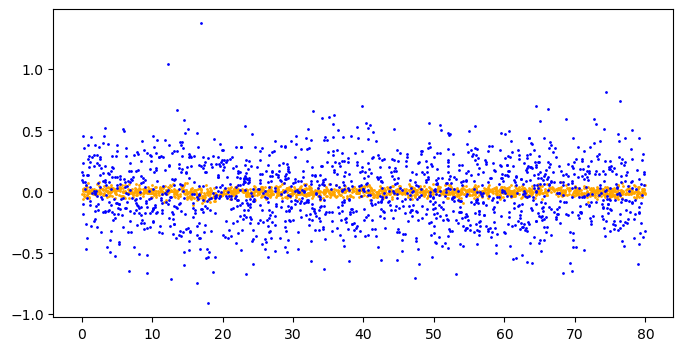

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)

k = 300
x_ion = np.load(f"results_MH_alfven/x_ion_{k}.npy")
x_electron = np.load(f"results_MH_alfven/x_electron_{k}.npy")
v_ion = np.load(f"results_MH_alfven/v_ion_{k}.npy")
v_electron = np.load(f"results_MH_alfven/v_electron_{k}.npy")

plt.scatter(x_ion[0, :], v_ion[0, :], s=1, color='orange')
plt.scatter(x_electron[0, :], v_electron[0, :], s=1, color='blue')
print(x_ion.shape[1], x_electron.shape[1])

In [ ]:
k = 0
U = np.load(f"results_MH_alfven/U1_{k}.npy")

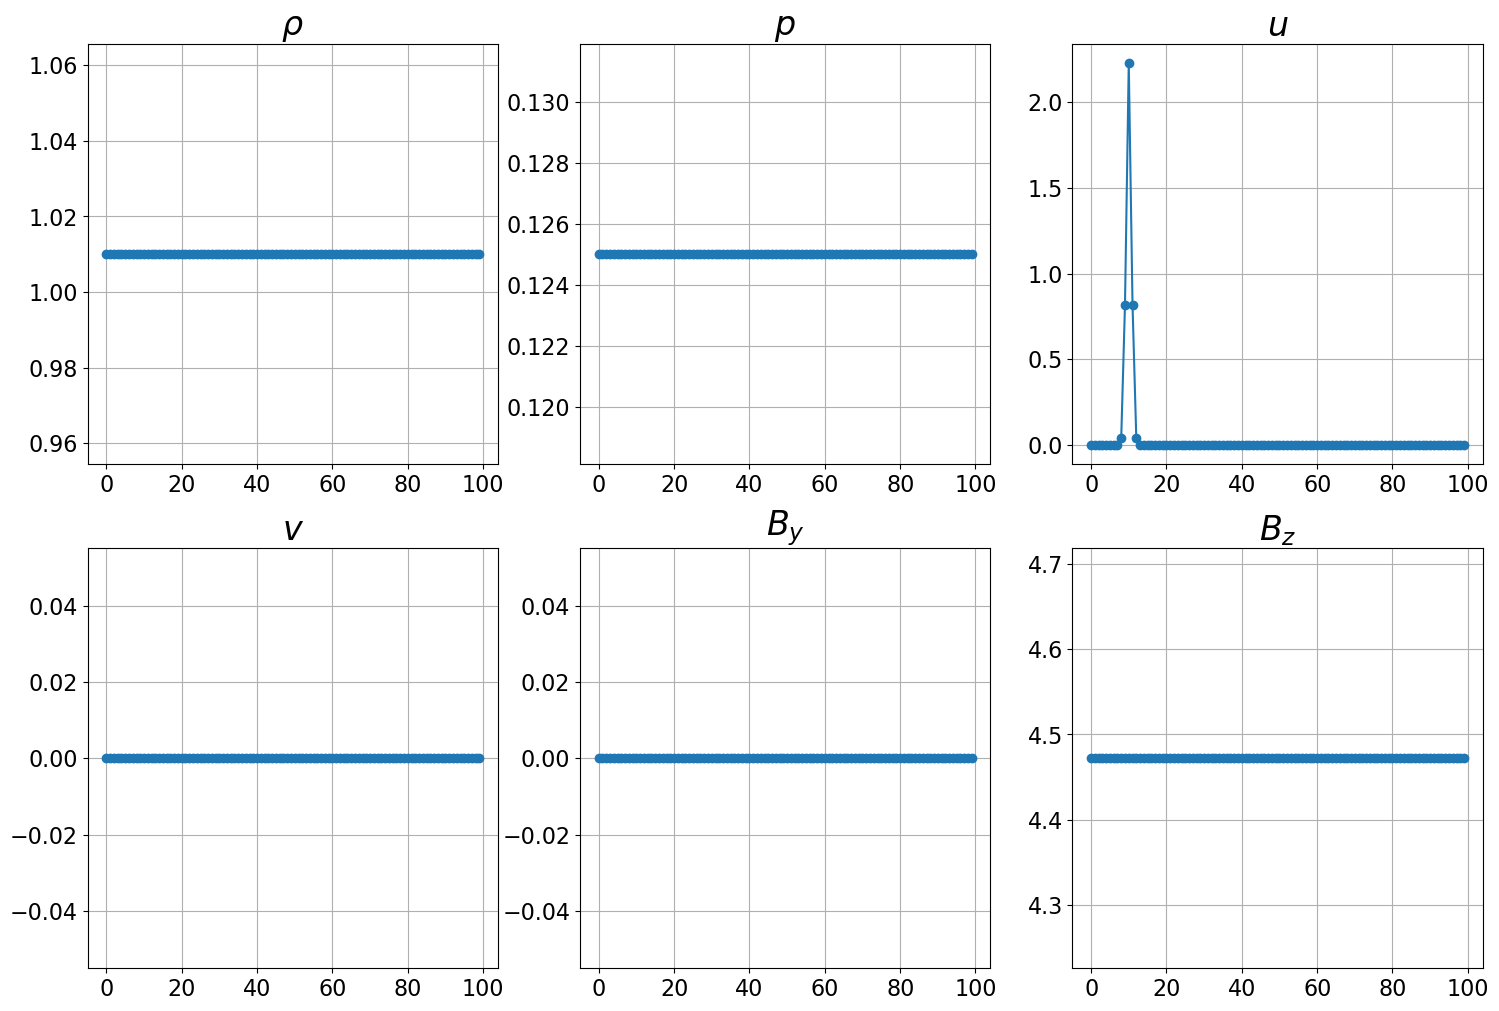

In [ ]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x_coordinate_mhd, rho, marker='o')
ax2.plot(x_coordinate_mhd, p, marker='o')
ax3.plot(x_coordinate_mhd, u, marker='o')
ax4.plot(x_coordinate_mhd, v, marker='o')
ax5.plot(x_coordinate_mhd, By, marker='o')
ax6.plot(x_coordinate_mhd, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

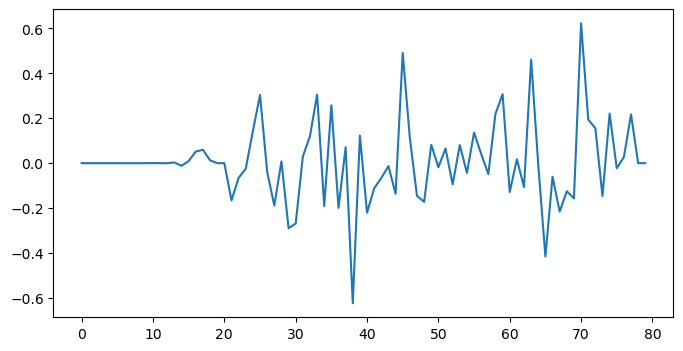

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)

k = 1000
E = np.load(f"results_MH_alfven/E_{k}.npy")
B = np.load(f"results_MH_alfven/B_{k}.npy")

plt.plot(x_coordinate_pic, B[1, :])